In [1]:
import pandas as pd
from fancyimpute import KNN
import re
import xlsxwriter
import numpy as np

#grpx
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor

from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

In [2]:
# Defina o caminho para o arquivo train.csv
file_path = r'C:\Users\Kkk\3D Objects\HCT\train.csv'

# Leia o arquivo CSV
df = pd.read_csv(file_path)
df2 = df.copy()
# Exiba as primeiras linhas do dataframe
#df.head()

In [3]:
df.describe()

,ID,hla_match_c_high,hla_high_res_8,hla_low_res_6,hla_high_res_6,hla_high_res_10,hla_match_dqb1_high,hla_nmdp_6,hla_match_c_low,hla_match_drb1_low,...,age_at_hct,hla_match_a_low,hla_match_b_high,comorbidity_score,karnofsky_score,hla_low_res_8,hla_match_drb1_high,hla_low_res_10,efs,efs_time
count,28800.000000,24180.000000,22971.000000,25530.000000,23516.000000,21637.000000,23601.000000,24603.000000,26000.000000,26157.000000,...,28800.000000,26410.000000,24712.00000,28323.000000,27930.00000,25147.000000,25448.000000,23736.000000,28800.000000,28800.000000
mean,14399.500000,1.764516,6.876801,5.143322,5.109202,8.617230,1.736876,5.160346,1.757808,1.715296,...,38.663162,1.709087,1.69962,1.702327,83.83208,6.903448,1.707128,8.664687,0.539306,23.237678
std,8313.988213,0.431941,1.564313,1.207757,1.214162,1.905125,0.447687,1.203240,0.435453,0.451282,...,21.147581,0.458259,0.46518,1.994443,11.02884,1.565017,0.461179,1.882746,0.498461,24.799748
min,0.000000,0.000000,2.000000,2.000000,0.000000,3.000000,0.000000,2.000000,0.000000,1.000000,...,0.044000,0.000000,0.00000,0.000000,40.00000,2.000000,0.000000,4.000000,0.000000,0.333000
25%,7199.750000,2.000000,6.000000,4.000000,4.000000,7.000000,1.000000,4.000000,2.000000,1.000000,...,19.539000,1.000000,1.00000,0.000000,70.00000,6.000000,1.000000,7.000000,0.000000,5.619750
50%,14399.500000,2.000000,8.000000,6.000000,6.000000,10.000000,2.000000,6.000000,2.000000,2.000000,...,41.006000,2.000000,2.00000,1.000000,90.00000,8.000000,2.000000,10.000000,1.000000,9.796500
75%,21599.250000,2.000000,8.000000,6.000000,6.000000,10.000000,2.000000,6.000000,2.000000,2.000000,...,55.965250,2.000000,2.00000,2.000000,90.00000,8.000000,2.000000,10.000000,1.000000,35.100000
max,28799.000000,2.000000,8.000000,6.000000,6.000000,10.000000,2.000000,6.000000,2.000000,2.000000,...,73.726000,2.000000,2.00000,10.000000,100.00000,8.000000,2.000000,10.000000,1.000000,156.819000


In [4]:
# Função para limpar caracteres especiais, tornar a variável uma palavra única e substituir valores específicos por ''
# Tratamento manual para 'cmv_status'
df['cmv_status'] = df['cmv_status'].replace({
    '+/+': 'mama', 
    '-/+': 'mema', 
    '+/-': 'mame', 
    '-/-': 'meme'
})
# Ajustar os nomes dos valores de 'tbi_status' para evitar conflitos após normalização
df['tbi_status'] = df['tbi_status'].replace({
    'TBI + Cy +- Other': 'TBICyOther',
    'TBI +- Other, <=cGy': 'TBIOtherlesscGy',
    'TBI +- Other, >cGy': 'TBIOthermorecGy',
    'TBI +- Other, -cGy, single': 'TBIOthercGysingle',
    'TBI +- Other, -cGy, fractionated': 'TBIOthercGyfractionated',
    'TBI +- Other, -cGy, unknown dose': 'TBIOthercGyunknowndose',
    'TBI +- Other, unknown dose': 'TBIOtherunknowndose'
})


def clean_unify_and_replace(column):
    column = column.astype(str).apply(lambda x: re.sub(r'\W+', '', x))
    column = column.replace({'nan': '', 'Missingdiseasestatus': '', 'Notdone': '', 'Nottested': ''})
    return column

# Aplicar a função em todas as colunas categóricas
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df[col] = clean_unify_and_replace(df[col])

# Transformação manual em numérico para variáveis categóricas o modelo knn
df['dri_score'] = df['dri_score'].replace({
    'Intermediate': 1, 'NApediatric': 2, 'High': 3,
    'NAnonmalignantindication': 4, 'TBDcytogenetics': 5, 'Low': 6,
    'HighTEDAMLcasemissingcytogenetics': 7, 'IntermediateTEDAMLcasemissingcytogenetics': 8,
    'NAdiseasenotclassifiable': 9, 'Veryhigh': 10
})

df['psych_disturb'] = df['psych_disturb'].replace({
    'No': 0, 'Yes': 1
})

df['cyto_score'] = df['cyto_score'].replace({
    'Poor': 1, 'Intermediate': 2, 'Favorable': 3,
    'TBD': 4, 'Normal': 5, 'Other': 6
})

df['diabetes'] = df['diabetes'].replace({
    'No': 0, 'Yes': 1
})

# Substituir valores na variável 'hla_high_res_8'
df['tbi_status'] = df['tbi_status'].replace({
    'NoTBI': '1',
    'TBICyOther': '2',
    'TBIOtherlesscGy': '3',
    'TBIOthermorecGy': '4',
    'TBIOthercGysingle': '5',
    'TBIOthercGyfractionated': '6',
    'TBIOthercGyunknowndose': '7',
    'TBIOtherunknowndose': '8',
})


df['arrhythmia'] = df['arrhythmia'].replace({
    'No': 0, 'Yes': 1
})

df['graft_type'] = df['graft_type'].replace({
    'Peripheralblood': 1, 'Bonemarrow': 2
})

df['vent_hist'] = df['vent_hist'].replace({
    'No': 0, 'Yes': 1
})

df['renal_issue'] = df['renal_issue'].replace({
    'No': 0, 'Yes': 1
})

df['pulm_severe'] = df['pulm_severe'].replace({
    'No': 0, 'Yes': 1
})

df['prim_disease_hct'] = df['prim_disease_hct'].replace({
    'ALL': 1, 'AML': 2, 'MDS': 3, 'IPA': 4, 'MPN': 5, 'IEA': 6, 
    'NHL': 7, 'IIS': 8, 'PCD': 9, 'SAA': 10, 'AI': 11, 'HIS': 12, 
    'Otherleukemia': 13, 'Solidtumor': 14, 'IMD': 15, 'Otheracuteleukemia': 16, 
    'HD': 17, 'CML': 18
})

df['cmv_status'] = df['cmv_status'].replace({
    'mama': 1, 'mema': 2, 'mame': 3, 'meme': 4
})

df['tce_imm_match'] = df['tce_imm_match'].replace({
    'PP': 1, 'GG': 2, 'HH': 3, 'GB': 4, 'HB': 5, 'PH': 6, 'PB': 7, 'PG': 8
})
df['rituximab'] = df['rituximab'].replace({
    'No': 0, 'Yes': 1
})

df['prod_type'] = df['prod_type'].replace({
    'PB': 1, 'BM': 2
})

df['cyto_score_detail'] = df['cyto_score_detail'].replace({
    'Intermediate': 1, 'Poor': 2, 'Favorable': 3, 'TBD': 4
})

df['conditioning_intensity'] = df['conditioning_intensity'].replace({
    'MAC': 1, 'RIC': 2, 'NMA': 3, 'TBD': 4, 'Nodrugsreported': 5, 'NAFpreTEDnotsubmitted': 6
})

df['ethnicity'] = df['ethnicity'].replace({
    'NotHispanicorLatino': 1, 'HispanicorLatino': 2, 'NonresidentoftheUS': 3
})

df['obesity'] = df['obesity'].replace({
    'No': 0, 'Yes': 1
})

df['mrd_hct'] = df['mrd_hct'].replace({
    'Negative': 0, 'Positive': 1
})

df['in_vivo_tcd'] = df['in_vivo_tcd'].replace({
    'No': 0, 'Yes': 1
})

df['tce_match'] = df['tce_match'].replace({
    'Permissive': 1, 'GvHnonpermissive': 2, 'Fullymatched': 3, 'HvGnonpermissive': 4
})

df['hepatic_severe'] = df['hepatic_severe'].replace({
    'No': 0, 'Yes': 1
})
df['prior_tumor'] = df['prior_tumor'].replace({
    'No': 0, 'Yes': 1
})

df['peptic_ulcer'] = df['peptic_ulcer'].replace({
    'No': 0, 'Yes': 1
})

df['gvhd_proph'] = df['gvhd_proph'].replace({
    'FKMMFothers': 1, 'Cyclophosphamidealone': 2, 'FKMTXothersnotMMF': 3,
    'Cyclophosphamideothers': 4, 'CSAMMFothersnotFK': 5, 'FKalone': 6,
    'OtherGVHDProphylaxis': 7, 'TDEPLETIONalone': 8, 'TDEPLETIONother': 9,
    'NoGvHDProphylaxis': 10, 'CDselectalone': 11, 'CSAMTXothersnotMMFFK': 12,
    'CSAalone': 13, 'ParentQyesbutnoagent': 14, 'CDselectother': 15, 
    'CSAothersnotFKMMFMTX': 16, 'FKothersnotMMFMTX': 17
})

df['rheum_issue'] = df['rheum_issue'].replace({
    'No': 0, 'Yes': 1
})

df['sex_match'] = df['sex_match'].replace({
    'MM': 1, 'FM': 2, 'MF': 3, 'FF': 4
})

df['race_group'] = df['race_group'].replace({
    'Morethanonerace': 1, 'Asian': 2, 'White': 3, 'BlackorAfricanAmerican': 4,
    'AmericanIndianorAlaskaNative': 5, 'NativeHawaiianorotherPacificIslander': 6
})

df['hepatic_mild'] = df['hepatic_mild'].replace({
    'No': 0, 'Yes': 1
})

df['tce_div_match'] = df['tce_div_match'].replace({
    'Permissivemismatched': 1, 'GvHnonpermissive': 2, 'HvGnonpermissive': 3,
    'Bidirectionalnonpermissive': 4
})

df['donor_related'] = df['donor_related'].replace({
    'Related': 1, 'Unrelated': 2, 'MultipledonornonUCB': 3
})

df['melphalan_dose'] = df['melphalan_dose'].replace({
    'NAMelnotgiven': 1, 'MEL': 2
})

df['cardiac'] = df['cardiac'].replace({
    'No': 0, 'Yes': 1
})

df['pulm_moderate'] = df['pulm_moderate'].replace({
    'No': 0, 'Yes': 1
})

# Verificar o DataFrame após a transformação manual
#print("DataFrame após a transformação manual:")
#print(df.head())
#print(df.info())


In [5]:
# Contar valores em cada variável no DataFrame original (df)
#print("Contagem de valores no DataFrame original (df):")
#print(df.count())

# Contar valores em cada variável no DataFrame imputado (df_imputed)
#print("\nContagem de valores no DataFrame imputado (df_imputed):")
#print(df2.count())


In [6]:
# Contagem das variáveis no DataFrame original (df)
#print("Contagem das variáveis em df:")
#for col in df.columns:
#    print(f"{col}: {df[col].value_counts()}")

# Contagem das variáveis no DataFrame imputado (df_imputed)
#print("\nContagem das variáveis em df_imputed:")
#for col in df_imputed.columns:
#    print(f"{col}: {df2[col].value_counts()}")


In [7]:
# Substituir strings vazias por np.nan
df.replace('', np.nan, inplace=True)

# Garantir que todas as colunas sejam numéricas
df = df.apply(pd.to_numeric, errors='coerce')

# Criar o modelo KNN Imputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

# Aplicar o modelo para imputar dados faltantes
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Selecionar as variáveis categóricas
categorical_cols = [
    'dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'tbi_status', 
    'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 
    'prim_disease_hct', 'cmv_status', 'tce_imm_match', 'rituximab', 'prod_type', 
    'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'obesity', 
    'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hepatic_severe', 'prior_tumor', 
    'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match', 'race_group', 
    'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'cardiac', 
    'pulm_moderate'
]

# Arredondar variáveis categóricas
for col in categorical_cols:
    df_imputed[col] = df_imputed[col].round(0).astype(int)

# Selecionar as variáveis numéricas a serem arredondadas
numeric_cols = [
    'hla_match_c_high', 'hla_high_res_8', 'hla_low_res_6', 'hla_high_res_6',
    'hla_high_res_10', 'hla_match_dqb1_high', 'hla_nmdp_6', 'hla_match_c_low',
    'hla_match_drb1_low', 'hla_match_dqb1_low', 'hla_match_a_high', 'hla_match_b_low',
    'hla_match_a_low', 'hla_match_b_high', 'comorbidity_score', 'hla_match_drb1_high',
    'hla_low_res_10'
]

# Arredondar variáveis numéricas
for col in numeric_cols:
    df_imputed[col] = df_imputed[col].round(0).astype(int)

# Arredondar karnofsky_score de 10 em 10
df_imputed['karnofsky_score'] = df_imputed['karnofsky_score'].round(-1).astype(int)

# Garantir que não haja valores vazios após imputação e arredondamento
# df_imputed.fillna(0, inplace=True)

# Verificar o DataFrame após a imputação e arredondamento das variáveis categóricas e numéricas
# print("DataFrame após a imputação e arredondamento das variáveis categóricas e numéricas:")
# print(df_imputed.head())
# print(df_imputed.info())


In [8]:
# Filtrar o DataFrame para manter apenas as variáveis categóricas
categorical_df = df_imputed[categorical_cols].copy()

# Reverter variáveis categóricas para suas representações originais
categorical_df['dri_score'] = categorical_df['dri_score'].replace({
    1: 'Intermediate', 2: 'NApediatric', 3: 'High',
    4: 'NAnonmalignantindication', 5: 'TBDcytogenetics', 6: 'Low',
    7: 'HighTEDAMLcasemissingcytogenetics', 8: 'IntermediateTEDAMLcasemissingcytogenetics',
    9: 'NAdiseasenotclassifiable', 10: 'Veryhigh'
})

categorical_df['psych_disturb'] = categorical_df['psych_disturb'].replace({
    0: 'No', 1: 'Yes'
})

categorical_df['cyto_score'] = categorical_df['cyto_score'].replace({
    1: 'Poor', 2: 'Intermediate', 3: 'Favorable',
    4: 'TBD', 5: 'Normal', 6: 'Other'
})

categorical_df['diabetes'] = categorical_df['diabetes'].replace({
    0: 'No', 1: 'Yes'
})

categorical_df['tbi_status'] = categorical_df['tbi_status'].replace({
    1: 'NoTBI', 2: 'TBICyOther', 3: 'TBIOtherlesscGy', 4: 'TBIOthermorecGy',
    5: 'TBIOthercGysingle', 6: 'TBIOthercGyfractionated', 7: 'TBIOthercGyunknowndose',
    8: 'TBIOtherunknowndose'
})

categorical_df['arrhythmia'] = categorical_df['arrhythmia'].replace({
    0: 'No', 1: 'Yes'
})

categorical_df['graft_type'] = categorical_df['graft_type'].replace({
    1: 'Peripheralblood', 2: 'Bonemarrow'
})

categorical_df['vent_hist'] = categorical_df['vent_hist'].replace({
    0: 'No', 1: 'Yes'
})

categorical_df['renal_issue'] = categorical_df['renal_issue'].replace({
    0: 'No', 1: 'Yes'
})

categorical_df['pulm_severe'] = categorical_df['pulm_severe'].replace({
    0: 'No', 1: 'Yes'
})

categorical_df['prim_disease_hct'] = categorical_df['prim_disease_hct'].replace({
    1: 'ALL', 2: 'AML', 3: 'MDS', 4: 'IPA', 5: 'MPN', 6: 'IEA', 
    7: 'NHL', 8: 'IIS', 9: 'PCD', 10: 'SAA', 11: 'AI', 12: 'HIS', 
    13: 'Otherleukemia', 14: 'Solidtumor', 15: 'IMD', 16: 'Otheracuteleukemia', 
    17: 'HD', 18: 'CML'
})

categorical_df['cmv_status'] = categorical_df['cmv_status'].replace({
    1: 'mama', 2: 'mema', 3: 'mame', 4: 'meme'
})

categorical_df['tce_imm_match'] = categorical_df['tce_imm_match'].replace({
    1: 'PP', 2: 'GG', 3: 'HH', 4: 'GB', 5: 'HB', 6: 'PH', 7: 'PB', 8: 'PG'
})

categorical_df['rituximab'] = categorical_df['rituximab'].replace({
    0: 'No', 1: 'Yes'
})

categorical_df['prod_type'] = categorical_df['prod_type'].replace({
    1: 'PB', 2: 'BM'
})

categorical_df['cyto_score_detail'] = categorical_df['cyto_score_detail'].replace({
    1: 'Intermediate', 2: 'Poor', 3: 'Favorable', 4: 'TBD'
})

categorical_df['conditioning_intensity'] = categorical_df['conditioning_intensity'].replace({
    1: 'MAC', 2: 'RIC', 3: 'NMA', 4: 'TBD', 5: 'Nodrugsreported', 6: 'NAFpreTEDnotsubmitted'
})

categorical_df['ethnicity'] = categorical_df['ethnicity'].replace({
    1: 'NotHispanicorLatino', 2: 'HispanicorLatino', 3: 'NonresidentoftheUS'
})

categorical_df['obesity'] = categorical_df['obesity'].replace({
    0: 'No', 1: 'Yes'
})

categorical_df['mrd_hct'] = categorical_df['mrd_hct'].replace({
    0: 'Negative', 1: 'Positive'
})

categorical_df['in_vivo_tcd'] = categorical_df['in_vivo_tcd'].replace({
    0: 'No', 1: 'Yes'
})

categorical_df['tce_match'] = categorical_df['tce_match'].replace({
    1: 'Permissive', 2: 'GvHnonpermissive', 3: 'Fullymatched', 4: 'HvGnonpermissive'
})

categorical_df['hepatic_severe'] = categorical_df['hepatic_severe'].replace({
    0: 'No', 1: 'Yes'
})

categorical_df['prior_tumor'] = categorical_df['prior_tumor'].replace({
    0: 'No', 1: 'Yes'
})

categorical_df['peptic_ulcer'] = categorical_df['peptic_ulcer'].replace({
    0: 'No', 1: 'Yes'
})

categorical_df['gvhd_proph'] = categorical_df['gvhd_proph'].replace({
    1: 'FKMMFothers', 2: 'Cyclophosphamidealone', 3: 'FKMTXothersnotMMF', 4: 'Cyclophosphamideothers',
    5: 'CSAMMFothersnotFK', 6: 'FKalone', 7: 'OtherGVHDProphylaxis', 8: 'TDEPLETIONalone', 9: 'TDEPLETIONother',
    10: 'NoGvHDProphylaxis', 11: 'CDselectalone', 12: 'CSAMTXothersnotMMFFK', 13: 'CSAalone', 14: 'ParentQyesbutnoagent',
    15: 'CDselectother', 16: 'CSAothersnotFKMMFMTX', 17: 'FKothersnotMMFMTX'
})

categorical_df['rheum_issue'] = categorical_df['rheum_issue'].replace({
    0: 'No', 1: 'Yes'
})

categorical_df['sex_match'] = categorical_df['sex_match'].replace({
    1: 'MM', 2: 'FM', 3: 'MF', 4: 'FF'
})

categorical_df['race_group'] = categorical_df['race_group'].replace({
    1: 'Morethanonerace', 2: 'Asian', 3: 'White', 4: 'BlackorAfricanAmerican', 5: 'AmericanIndianorAlaskaNative', 
    6: 'NativeHawaiianorotherPacificIslander'
})

categorical_df['hepatic_mild'] = categorical_df['hepatic_mild'].replace({
    0: 'No', 1: 'Yes'
})

categorical_df['tce_div_match'] = categorical_df['tce_div_match'].replace({
    1: 'Permissivemismatched', 2: 'GvHnonpermissive', 3: 'HvGnonpermissive', 4: 'Bidirectionalnonpermissive'
})

categorical_df['donor_related'] = categorical_df['donor_related'].replace({
    1: 'Related', 2: 'Unrelated', 3: 'MultipledonornonUCB'
})

categorical_df['melphalan_dose'] = categorical_df['melphalan_dose'].replace({
    1: 'NAMelnotgiven', 2: 'MEL'
})

categorical_df['cardiac'] = categorical_df['cardiac'].replace({
    0: 'No', 1: 'Yes'
})

categorical_df['pulm_moderate'] = categorical_df['pulm_moderate'].replace({
    0: 'No', 1: 'Yes'
})

In [9]:
# Montar o DataFrame final com as variáveis categóricas revertidas
df_final = df_imputed.copy()

# Atualizar o DataFrame final com as variáveis categóricas revertidas
df_final[categorical_cols] = categorical_df

# Salvar o DataFrame final em um arquivo CSV
df2.to_csv('df2.csv', index=False)

In [10]:
# Calcular estatísticas descritivas 
numeric_stats = df_imputed[numeric_cols].describe() 
print(numeric_stats)

       hla_match_c_high  hla_high_res_8  hla_low_res_6  hla_high_res_6  \
count      28800.000000    28800.000000   28800.000000    28800.000000   
mean           1.785243        6.866007       5.136458        5.100243   
std            0.417287        1.439883       1.155678        1.128803   
min            0.000000        2.000000       2.000000        0.000000   
25%            2.000000        6.000000       4.000000        4.000000   
50%            2.000000        8.000000       6.000000        6.000000   
75%            2.000000        8.000000       6.000000        6.000000   
max            2.000000        8.000000       6.000000        6.000000   

       hla_high_res_10  hla_match_dqb1_high    hla_nmdp_6  hla_match_c_low  \
count     28800.000000         28800.000000  28800.000000     28800.000000   
mean          8.606319             1.760521      5.152812         1.769028   
std           1.715872             0.432993      1.135533         0.427921   
min           3.00000

Estatísticas Descritivas das Variáveis Numéricas:
       hla_match_c_high  hla_high_res_8  hla_low_res_6  hla_high_res_6  \
count      24180.000000    22971.000000   25530.000000    23516.000000   
mean           1.764516        6.876801       5.143322        5.109202   
std            0.431941        1.564313       1.207757        1.214162   
min            0.000000        2.000000       2.000000        0.000000   
25%            2.000000        6.000000       4.000000        4.000000   
50%            2.000000        8.000000       6.000000        6.000000   
75%            2.000000        8.000000       6.000000        6.000000   
max            2.000000        8.000000       6.000000        6.000000   

       hla_high_res_10  hla_match_dqb1_high    hla_nmdp_6  hla_match_c_low  \
count     21637.000000         23601.000000  24603.000000     26000.000000   
mean          8.617230             1.736876      5.160346         1.757808   
std           1.905125             0.447687      

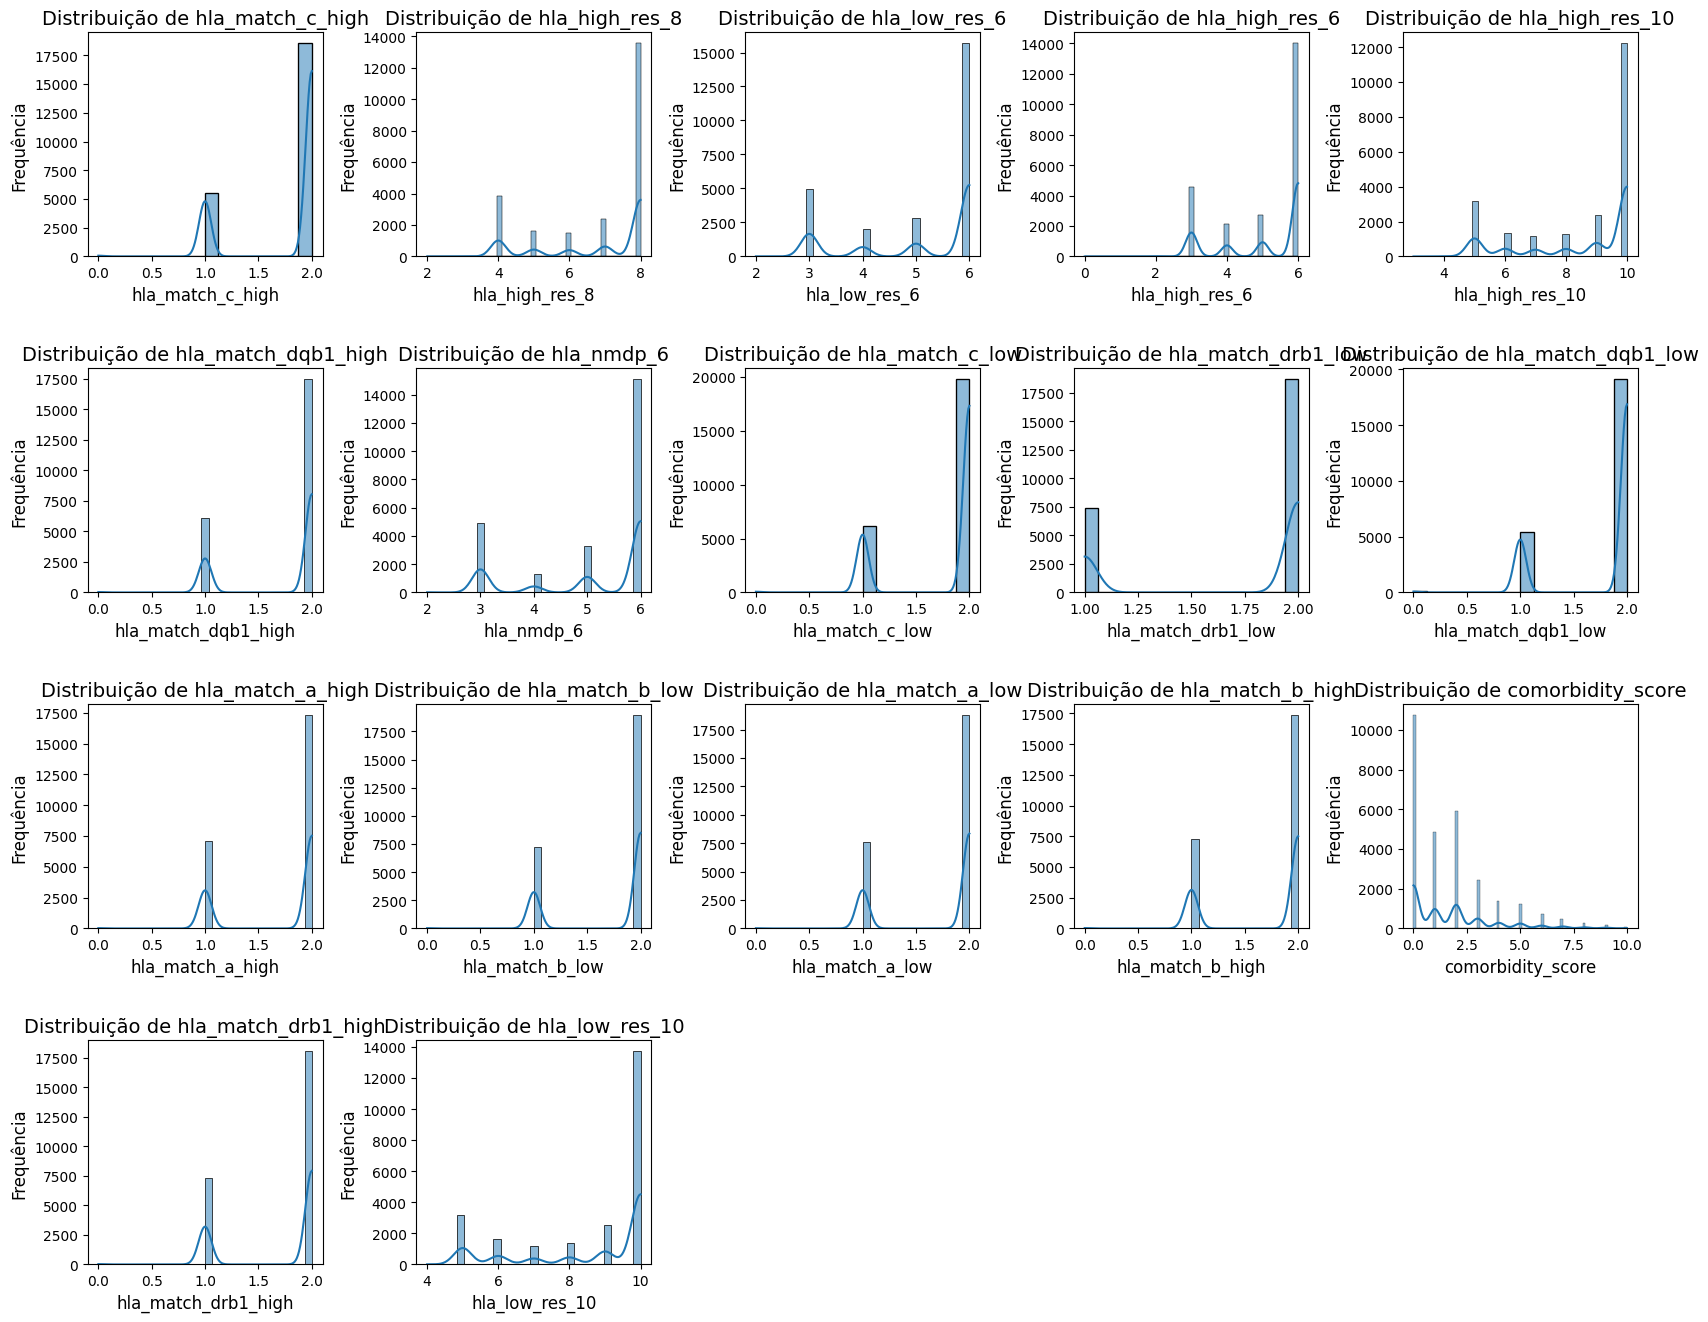

In [14]:
# Estatísticas descritivas para variáveis numéricas
numeric_stats = df[numeric_cols].describe()
print("Estatísticas Descritivas das Variáveis Numéricas:")
print(numeric_stats)

# Configurar o layout da grade
num_cols = 5
num_rows = len(numeric_cols) // num_cols + 1

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 4))
fig.subplots_adjust(hspace=0.5, wspace=0.4)

# Criar gráficos para cada variável numérica
for i, col in enumerate(numeric_cols):
    row = i // num_cols
    col_position = i % num_cols
    sns.histplot(df[col], kde=True, ax=axes[row, col_position])
    axes[row, col_position].set_title(f'Distribuição de {col}', fontsize=14)
    axes[row, col_position].set_xlabel(col, fontsize=12)
    axes[row, col_position].set_ylabel('Frequência', fontsize=12)

# Remover eixos não utilizados
for j in range(i + 1, num_rows * num_cols):
    fig.delaxes(axes.flatten()[j])

plt.show()

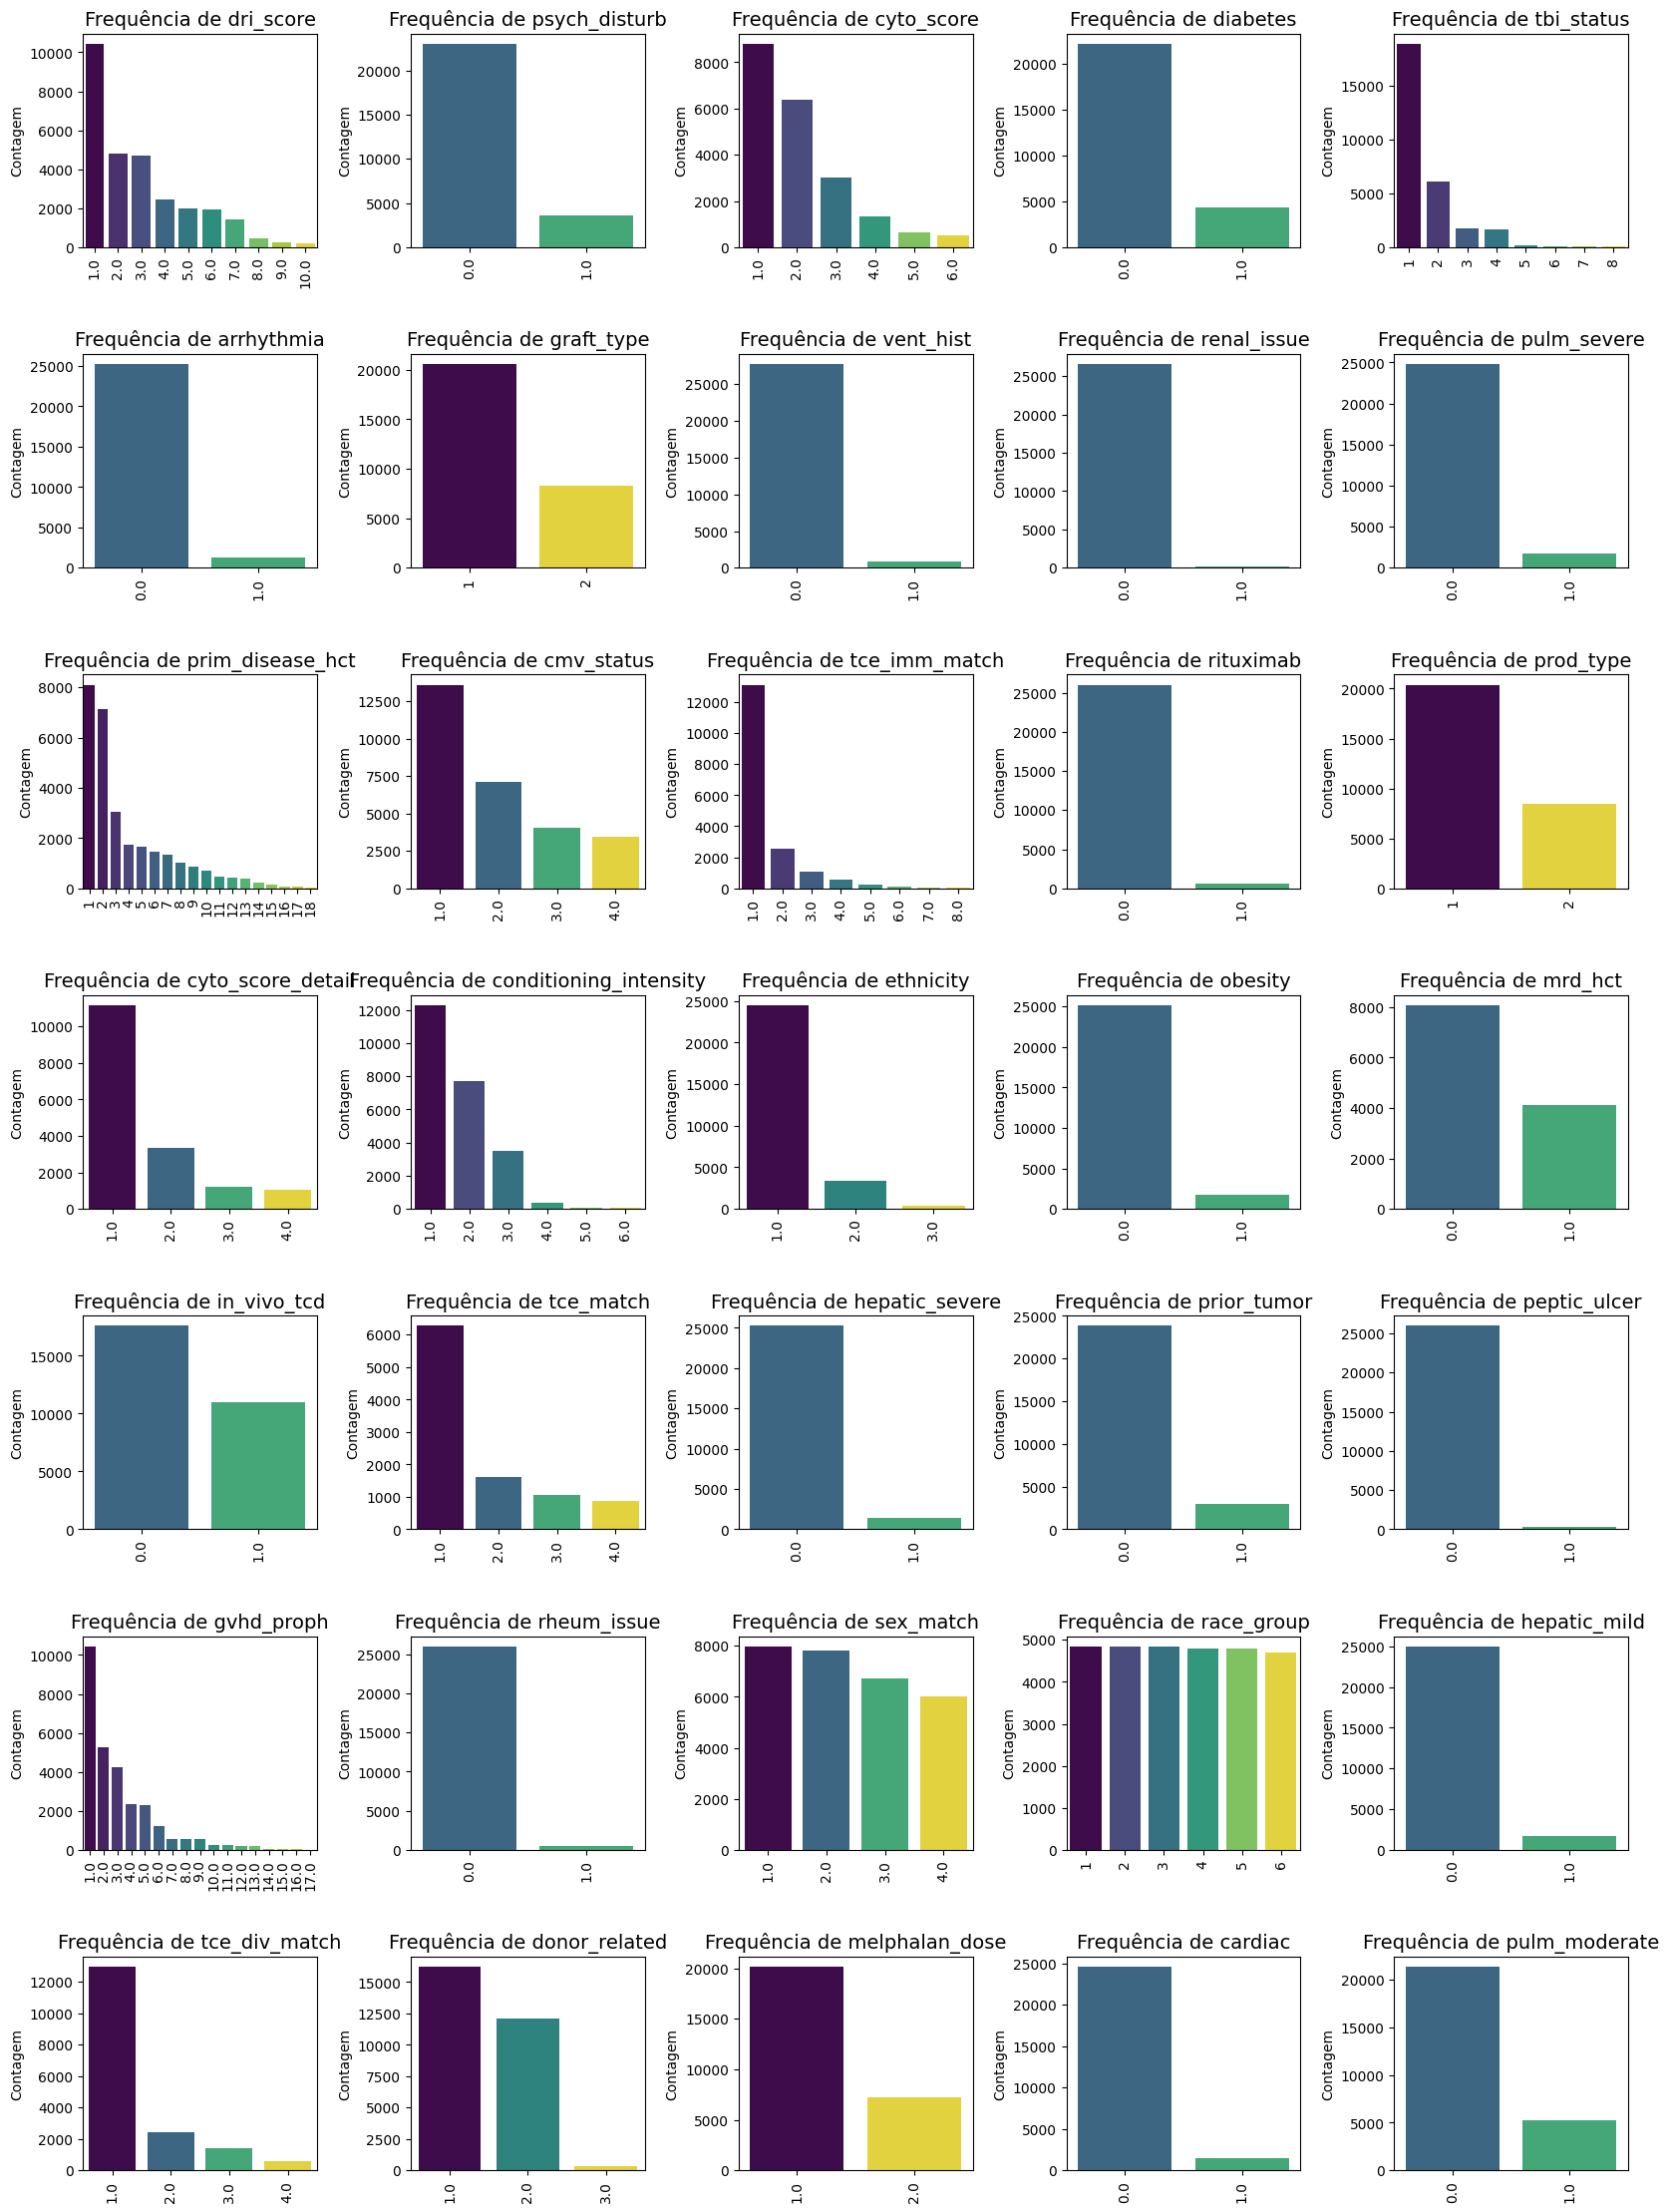

In [12]:
# Configurar o layout da grade
num_cols = 5
num_rows = len(categorical_cols) // num_cols + 1

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 4))
fig.subplots_adjust(hspace=0.5, wspace=0.4)

# Criar gráficos para cada variável categórica
for i, col in enumerate(categorical_cols):
    row = i // num_cols
    col_position = i % num_cols
    sns.countplot(data=df, x=col, hue=col, palette='viridis', order=df[col].value_counts().index, ax=axes[row, col_position], legend=False)
    axes[row, col_position].set_title(f'Frequência de {col}', fontsize=14)
    axes[row, col_position].set_xlabel('')
    axes[row, col_position].set_ylabel('Contagem')
    axes[row, col_position].tick_params(axis='x', rotation=90)

# Remover eixos não utilizados
for j in range(i + 1, num_rows * num_cols):
    fig.delaxes(axes.flatten()[j])

plt.show()

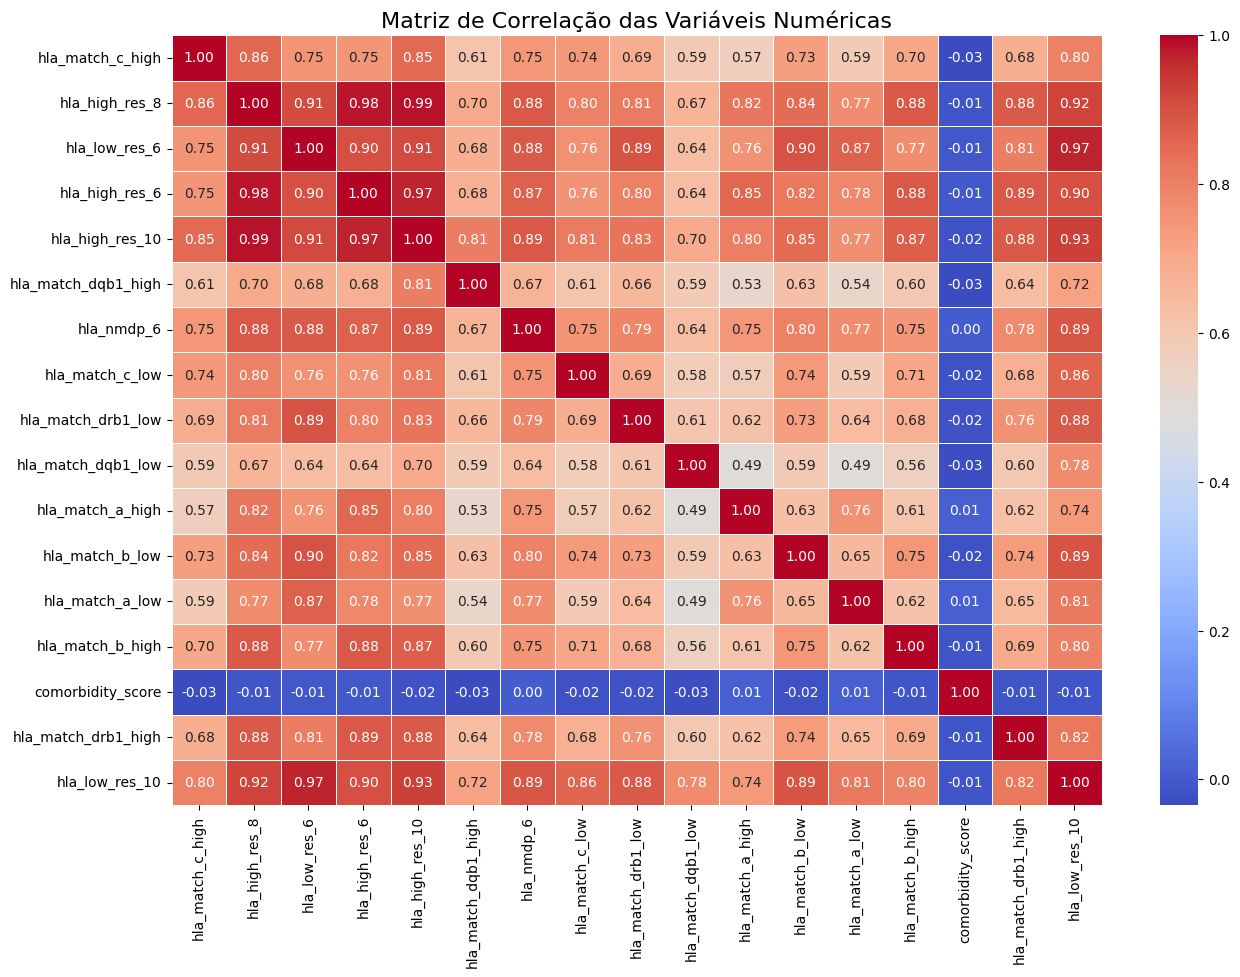

In [15]:
# Calcular a matriz de correlação
correlation_matrix = df[numeric_cols].corr()

# Configurar o tamanho da figura
plt.figure(figsize=(15, 10))

# Criar um heatmap da matriz de correlação
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Título do heatmap
plt.title('Matriz de Correlação das Variáveis Numéricas', fontsize=16)

# Mostrar o heatmap
plt.show()

In [18]:
import scipy.stats as stats

# Selecionar a variável alvo (por exemplo, sobrevida após 1 ano)
target_variable = 'efs'

# Tabelas de contingência e teste qui-quadrado
for col in categorical_cols:
    contingency_table = pd.crosstab(df[col], df[target_variable])
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    print(f'Variável: {col}')
    print(f'Tabela de Contingência:\n{contingency_table}')
    print(f'Chi2: {chi2}, p-valor: {p}')
    print('-' * 50)


Variável: dri_score
Tabela de Contingência:
efs         0.0   1.0
dri_score            
1.0        4303  6133
2.0        2916  1863
3.0        1383  3318
4.0        1484   943
5.0        1217   786
6.0         783  1143
7.0         584   830
8.0         216   265
9.0         172   100
10.0        118    80
Chi2: 1531.5826878690555, p-valor: 0.0
--------------------------------------------------
Variável: psych_disturb
Tabela de Contingência:
efs              0.0    1.0
psych_disturb              
0.0            10956  12049
1.0             1359   2228
Chi2: 117.9505845997841, p-valor: 1.77762011291431e-27
--------------------------------------------------
Variável: cyto_score
Tabela de Contingência:
efs          0.0   1.0
cyto_score            
1.0         3334  5468
2.0         2545  3831
3.0         1207  1804
4.0          574   767
5.0          248   395
6.0          222   282
Chi2: 21.056890458142014, p-valor: 0.0007902543518090385
--------------------------------------------------